In [1]:
# We will need some functionality 
from typing import List 

import time

# and from math related libraries
import qutip as qt

import matplotlib.pyplot as plt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator

import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

from qiskit.utils.mitigation import CompleteMeasFitter

from qiskit.circuit import Parameter

In [2]:
def analog_ansatz(analog_block,num_qubits,repeats=1):

    qr = QuantumRegister(num_qubits)
    ansatz = QuantumCircuit(qr)
    
    parameter_matrix = [ [Parameter('a{}'.format(i)) for i in range(int(np.ceil(num_qubits/2)))] , [Parameter('b{}'.format(j)) for j in range(num_qubits)]]
    
    for r in range(repeats):
        for q in range(num_qubits):
            theta = parameter_matrix[1][q]
            
            # add single-qubit rotation gates to all for variational parameter
            #ansatz.rx(psi, q)

            # add single-qubit rotation gates to all for second variational parameter
            #ansatz.rz(theta, q)

            if q % 2 == 0:
                    psi = parameter_matrix[0][int(q/2)]
                    ansatz.rx(psi, q)
            ansatz.rz(theta, q)

            # add some single-qubit gates
            #for i in range(num_qubits-1):
            # if q == 0:
            #     ansatz.rx(psi_0, q)
            #     ansatz.rz(theta_0, q)
            # else:    
            #     ansatz.rz(theta_1, q)

        
        # analog block for multi-qubit mixing
        ansatz.unitary(analog_block, [qr[i] for i in range(num_qubits)], label='analog block')

    ansatz.barrier()
    
    return ansatz

def digital_ansatz(num_qubits,repeats=1):
    psi = Parameter('a')
    theta = Parameter('b')
 
    ansatz = QuantumCircuit(num_qubits)
    
    for i in range(num_qubits-1):
        if i % 2 == 0:
            ansatz.rx(psi, i)

    ansatz.rz(theta, range(num_qubits))
        
    for r in range(repeats):
#         # add single-qubit rotation gates to all for variational parameter
#         ansatz.rx(psi, range(num_qubits))
        
#         # add single-qubit rotation gates to all for second variational parameter
#         ansatz.rz(theta, range(num_qubits))

#         # add chain of CNOTS for multi-qubit mixing
#         for i in range(num_qubits-1):
#             ansatz.cx(i, i+1)
#         ansatz.cx(num_qubits-1,0)
        
        # add some single-qubit gates

    
        # add a chain of CNOTs (multi-qubit gates)
        for i in range(num_qubits-1):
            ansatz.cx(i, i+1)
        ansatz.cx(num_qubits-1,0)
    
    ansatz.barrier()
    
    return ansatz

In [3]:

seed = 170
iterations = 500
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

def get_conv_time(steps,vals,stable_time=50,error=0.0001):
    local_vals = vals[0:stable_time-1]
    for t in range(len(vals)-stable_time-1):
        local_error = abs(max(local_vals) - min(local_vals))/abs(np.mean(local_vals))
        #print(np.std(local_vals),np.mean(local_vals))
        if local_error <= error:
            #print(local_vals)
            return t
        else:
            local_vals.append(vals[t+stable_time])
            del local_vals[0]
            if t == len(vals)-stable_time-2:
                return t
    

def get_eigenvalue(which,num_qubits,ham_op,repeats=1,analog_block=0.0,print_bool=False):
    counts = []
    values = []
    if which == "digital":
        chosen_ansatz = digital_ansatz(num_qubits,repeats)#TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')#
    else:
        chosen_ansatz = analog_ansatz(analog_block,num_qubits,repeats)
    
    if print_bool:
        print(chosen_ansatz)
        
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(chosen_ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=ham_op)
    final_eigval = abs(result.eigenvalue.real)
    conv_time = get_conv_time(counts,values)/(counts[-1]-50)
    
    return final_eigval,values,conv_time

def get_ham_operator(num_qubits,connectivity,coefficient):
    ham_op = 0.0 * I
    for h in range(num_qubits-1):
        ham_op ^= I

    for i in range(num_qubits):
        for j in range(num_qubits):
            elements = [I for q in range(num_qubits)]
            if connectivity[i][j] == 1:
                elements[i] = Z
                elements[j] = Z
                new_component = coefficient * elements[0]
                for e in range(len(elements)-1):
                    new_component ^= elements[e+1]
                ham_op += (new_component)
    return ham_op

def get_connections_matrix(which_graph):
    num_qubits = 4
    connectivity = [[0 for j in range(num_qubits)] for i in range(num_qubits)]
    connectivity[0][1] = 1
    connectivity[1][2] = 1
    rec_coeff = 2
    if which_graph == 2:
        connectivity[1][3] = 1
        rec_coeff += 1
    elif which_graph == 1:
        connectivity[2][3] = 1
        rec_coeff += 1
    elif which_graph > 2:
        connectivity[2][3] = 1
        rec_coeff += 1
        if which_graph == 3:
            connectivity[3][0] = 1
            rec_coeff += 1
        else:
            connectivity[1][3] = 1
            rec_coeff += 1
            if which_graph > 4:
                connectivity[3][0] = 1
                rec_coeff += 1
                if which_graph == 6:
                    connectivity[2][0] = 1
                    rec_coeff += 1
    return connectivity, 1/rec_coeff
        
def plot_connectivity(connectivity):
    num_qubits = 4
    location_dict = {"0":[0.0,1.0], "1":[0.0,0.0], "2":[1.0,0.0], "3":[1.0,1.0]}
    xs = []
    ys = []
    for i in range(num_qubits):
        for j in range(num_qubits):
            if connectivity[i][j] == 1:
                xs.append(location_dict['{}'.format(i)][0])
                xs.append(location_dict['{}'.format(j)][0])
                ys.append(location_dict['{}'.format(i)][1])
                ys.append(location_dict['{}'.format(j)][1])
    for j in range(int(len(xs)/2)):
        plt.plot(xs[2*j:2*j+2],ys[2*j:2*j+2],"-ob")
    return xs,ys

#     print(which,": ",final_eigval)
    
#     pylab.rcParams['figure.figsize'] = (12, 4)
#     pylab.plot(counts, values, label=which)
#     pylab.xlabel('Eval count')
#     pylab.ylabel('Energy')
#     pylab.legend()
#     pylab.title('Convergence with noise, measurement error mitigation enabled');
    
    

Coefficient Recommended 0.3333333333333333
Number of qubits: 4
Data Gathered 1/5
Data Gathered 2/5
Data Gathered 3/5
Data Gathered 4/5
Data Gathered 5/5


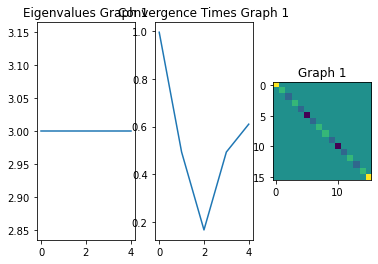

Coefficient Recommended 0.3333333333333333
Number of qubits: 4
Data Gathered 1/5
Data Gathered 2/5
Data Gathered 3/5
Data Gathered 4/5
Data Gathered 5/5


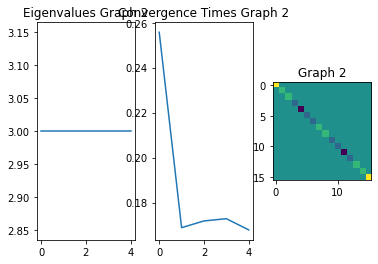

Coefficient Recommended 0.25
Number of qubits: 4
Data Gathered 1/5
Data Gathered 2/5
Data Gathered 3/5
Data Gathered 4/5
Data Gathered 5/5


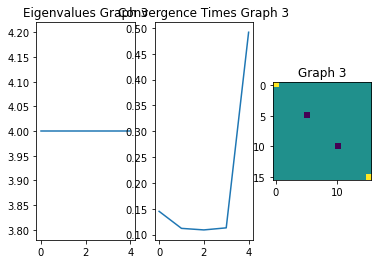

Coefficient Recommended 0.25
Number of qubits: 4
Data Gathered 1/5
Data Gathered 2/5
Data Gathered 3/5
Data Gathered 4/5
Data Gathered 5/5


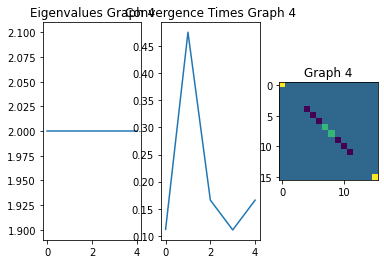

Coefficient Recommended 0.2
Number of qubits: 4
Data Gathered 1/5
Data Gathered 2/5
Data Gathered 3/5
Data Gathered 4/5
Data Gathered 5/5


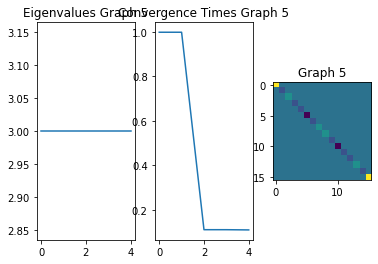

Coefficient Recommended 0.16666666666666666
Number of qubits: 4
Data Gathered 1/5
Data Gathered 2/5
Data Gathered 3/5
Data Gathered 4/5
Data Gathered 5/5


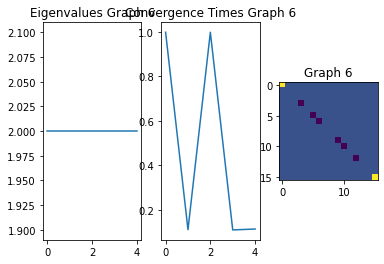

In [5]:
#H2_op = (-1.052373245772859 * I ^ I) + (0.39793742484318045 * I ^ Z) + (-0.39793742484318045 * Z ^ I) + (-0.01128010425623538 * Z ^ Z) + (0.18093119978423156 * X ^ X)
qubits_count = 4

for chosen_graph in [1,2,3,4,5,6]:
    #chosen_graph = 2
    connections,coeff = get_connections_matrix(chosen_graph)
    print("Coefficient Recommended",coeff)

    chosen_op = get_ham_operator(qubits_count,connections,1.0)

    hamiltonian = chosen_op.to_matrix()
    ham_block = HamiltonianGate(data=hamiltonian, time=2) 

    print(f'Number of qubits: {chosen_op.num_qubits}')

    ana_conv_times = []
    #ana_conv_series = []
    ana_eig_vals = []
    blocks = 1
    for it in range(5):
        printing = False
        ana_dats = get_eigenvalue("analog",qubits_count,chosen_op,blocks,ham_block,printing)

        #ana_conv_series.append(ana_dats[1])
        ana_conv_times.append(ana_dats[2])
        ana_eig_vals.append(ana_dats[0])

        print('Data Gathered {}/5'.format(it+1))

    figure, axis = plt.subplots(1,3)
    axis[0].plot(ana_eig_vals)
    axis[0].set_title("Eigenvalues Graph {}".format(chosen_graph))

    axis[1].plot(ana_conv_times)
    axis[1].set_title("Convergence Times Graph {}".format(chosen_graph))
    
    axis[2].imshow(np.real(hamiltonian))
    #axis[2].colorbar()
    axis[2].set_title('Graph {}'.format(chosen_graph));
    plt.show()

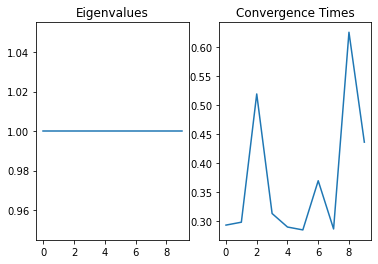

In [7]:
figure, axis = plt.subplots(1,2)
axis[0].plot(ana_eig_vals)
axis[0].set_title("Eigenvalues")

# for i in range(top_block):
#     axis[1].plot([j for j in range(len(ana_conv_series[i]))],ana_conv_series[i],label='A{}'.format(i+1))
#     #axis[1].plot(block_counts,dig_conv_times[i],label="Digital")
#     axis[1].set_title("Convergence Series")
    
#for i in range(top_block):
#    axis[2].plot([j for j in range(len(ana_conv_series[i]))],ana_conv_series[i],label='A{}'.format(block_counts[i]))
#    axis[2].set_title("Convergence Series")

#axis[2].legend()

axis[1].plot(ana_conv_times)
axis[1].set_title("Convergence Times");